In [1]:
pip install rasterio numpy opencv-python tqdm

Note: you may need to restart the kernel to use updated packages.


In [8]:
import rasterio
import numpy as np
import os
import cv2
from tqdm import tqdm

In [52]:
# Charleston flood
before_path = './201610Charleston/201610Charleston_BF.tif'
after_path = './201610Charleston/201610Charleston_AF.tif'
mask_path = './201610Charleston/201610Charleston_FM.tif'
permanent_water_path = './201610Charleston/201610Charleston_PWL.tif'

with rasterio.open(before_path) as before_src:
    before_img = before_src.read(1)

with rasterio.open(after_path) as after_src:
    after_img = after_src.read(1)

with rasterio.open(mask_path) as mask_src:
    mask_img = mask_src.read(1)

with rasterio.open(permanent_water_path) as permanent_water_src:
    permanent_water_img = permanent_water_src.read(1)




In [56]:
# Mississipi Flood
# Charleston flood
before_path = './201905Mississipi/201905Mississipi_BF.tif'
after_path = './201905Mississipi/201905Mississipi_AF.tif'
mask_path = './201905Mississipi/201905Mississipi_FM.tif'
permanent_water_path = './201905Mississipi/201905Mississipi_PWL.tif'

with rasterio.open(before_path) as before_src:
    before_img = before_src.read(1)

with rasterio.open(after_path) as after_src:
    after_img = after_src.read(1)

with rasterio.open(mask_path) as mask_src:
    mask_img = mask_src.read(1)

with rasterio.open(permanent_water_path) as permanent_water_src:
    permanent_water_img = permanent_water_src.read(1)




In [60]:
# Valencia Flood
before_path = './202410Valencia/202410Valencia_BF.tif'
after_path = './202410Valencia/202410Valencia_AF.tif'
mask_path = './202410Valencia/202410Valencia_FM.tif'
permanent_water_path = './202410Valencia/202410Valencia_PWL.tif'

with rasterio.open(before_path) as before_src:
    before_img = before_src.read(1)

with rasterio.open(after_path) as after_src:
    after_img = after_src.read(1)

with rasterio.open(mask_path) as mask_src:
    mask_img = mask_src.read(1)

with rasterio.open(permanent_water_path) as permanent_water_src:
    permanent_water_img = permanent_water_src.read(1)


In [61]:
def create_chips(image, chip_size, step):
    h, w = image.shape
    chips = []
    for i in range(0, h - chip_size + 1, step):
        for j in range(0, w - chip_size + 1, step):
            chip = image[i:i + chip_size, j:j + chip_size]
            chips.append(chip)
    return chips

chip_size = 256
step = chip_size // 2  # 50% overlap

before_chips = create_chips(before_img, chip_size, step)
after_chips = create_chips(after_img, chip_size, step)
mask_chips = create_chips(mask_img, chip_size, step)
water_chips = create_chips(permanent_water_img, chip_size, step)

In [62]:
def save_chips(chips, output_dir, image_path):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    prefix = os.path.basename(image_path).split('_')[0]
    for idx, chip in enumerate(tqdm(chips)):
        output_path = os.path.join(output_dir, f"{prefix}_{idx}.png")
        cv2.imwrite(output_path, chip)

# Save chips for each category
save_chips(before_chips, 'chips/before', before_path)
save_chips(after_chips, 'chips/after', after_path)
save_chips(mask_chips, 'chips/mask', mask_path)
save_chips(water_chips, 'chips/water', permanent_water_path)

100%|██████████| 588/588 [00:00<00:00, 2106.75it/s]


In [63]:
# step 8: creating JSON metadata file
def create_metadata(chips, output_dir, image_path, corresponding_images):
    metadata = []
    prefix = os.path.basename(image_path).split('_')[0]

    for idx, chip in enumerate(chips):
        entry = {
            "id": f"{prefix}_{idx}",
            "image_path": os.path.join(output_dir, f"{prefix}_{idx}.png"),
            "source_image": image_path,
            "before_image": corresponding_images.get("before"),
            "after_image": corresponding_images.get("after"),
            "coordinates": (idx // 256, idx % 256)  # Example coordinate, adjust as needed
        }
        metadata.append(entry)

    with open(os.path.join(output_dir, f"{prefix}_metadata.json"), 'w') as json_file:
        json.dump(metadata, json_file, indent=4)

# Use this modified function to create metadata for all categories, while providing corresponding images
create_metadata(mask_chips, 'chips/mask', mask_path, {"before": before_path, "after": after_path})
create_metadata(water_chips, 'chips/water', permanent_water_path, {"before": before_path, "after": after_path})
create_metadata(before_chips, 'chips/before', before_path, {"mask": mask_path, "water": permanent_water_path})
create_metadata(after_chips, 'chips/after', after_path, {"mask": mask_path, "water": permanent_water_path})

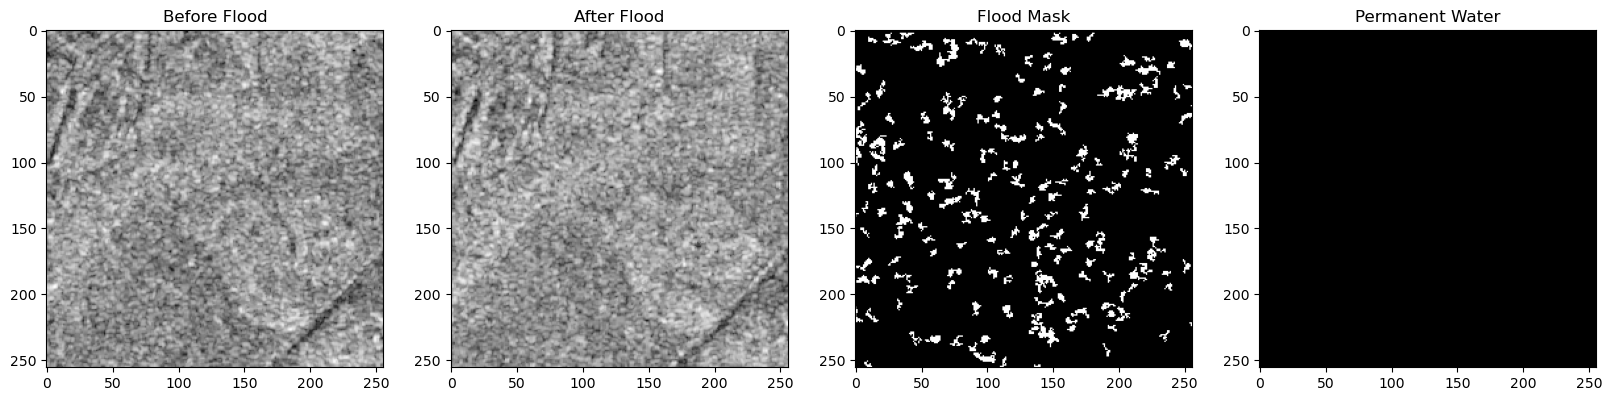

In [20]:
# Step 8: visualize the chips
import matplotlib.pyplot as plt

def plot_chip(before, after, mask, water):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow(before, cmap='gray')
    axs[0].set_title('Before Flood')
    axs[1].imshow(after, cmap='gray')
    axs[1].set_title('After Flood')
    axs[2].imshow(mask, cmap='gray')
    axs[2].set_title('Flood Mask')
    axs[3].imshow(water, cmap='gray')
    axs[3].set_title('Permanent Water')
    plt.show()

plot_chip(before_chips[10], after_chips[10], mask_chips[10], water_chips[10])

In [33]:
def augment_chip(chip):
    flipped = cv2.flip(chip, 1)  # Horizontal flip
    rotated = cv2.rotate(chip, cv2.ROTATE_90_CLOCKWISE)  # Rotate 90 degrees
    return [chip, flipped, rotated]

In [34]:
before_normalized = [chip / 255.0 for chip in before_chips]
after_normalized = [chip / 255.0 for chip in after_chips]
mask_normalized = [chip / 255.0 for chip in mask_chips]
water_normalized = [chip / 255.0 for chip in water_chips]

In [31]:
#Step 9: splitting dataset into train, validation, and test sets
from sklearn.model_selection import train_test_split

# Combine all chips into a list of tuples, keeping track of original names
all_chips = list(zip(before_chips, after_chips, mask_chips, water_chips))
original_names = [f"{os.path.basename(before_path).split('.')[0]}_{idx}" for idx in range(len(before_chips))]

# Split into training, validation, and test sets
train_val_chips, test_chips, train_val_names, test_names = train_test_split(all_chips, original_names, test_size=0.15, random_state=42)
train_chips, val_chips, train_names, val_names = train_test_split(train_val_chips, train_val_names, test_size=0.15 / 0.85, random_state=42)

# Separate the chips again for saving
before_train, after_train, mask_train, water_train = zip(*train_chips)
before_val, after_val, mask_val, water_val = zip(*val_chips)
before_test, after_test, mask_test, water_test = zip(*test_chips)
train_names, val_names, test_names = list(train_names), list(val_names), list(test_names)

In [32]:
# saving the splitted dataset
save_chips(before_train, 'splitted_chips/train/before', 'before')
save_chips(after_train, 'splitted_chips/train/after', 'after')
save_chips(mask_train, 'splitted_chips/train/mask', 'mask')
save_chips(water_train, 'splitted_chips/train/water', 'water')

save_chips(before_val, 'splitted_chips/val/before', 'before')
save_chips(after_val, 'splitted_chips/val/after', 'after')
save_chips(mask_val, 'splitted_chips/val/mask', 'mask')
save_chips(water_val, 'splitted_chips/val/water', 'water')

save_chips(before_test, 'splitted_chips/test/before', 'before')
save_chips(after_test, 'splitted_chips/test/after', 'after')
save_chips(mask_test, 'splitted_chips/test/mask', 'mask')
save_chips(water_test, 'splitted_chips/test/water', 'water')

100%|██████████| 168/168 [00:00<00:00, 1730.02it/s]
